# Topological Data Analysis in NLP tasks


In [3]:
!pip install pandas kmapper numpy scikit-learn deeppavlov torch matplotlib
!pip install transformers 
!pip install pytorch-transformers
!pip install dionysus
!pip install scikit-tda

     |████████████████████████████████| 69 kB 888 kB/s eta 0:00:011
     |████████████████████████████████| 81 kB 5.1 MB/s eta 0:00:011


  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67948 sha256=558534f6fde54244267f9da2201f4779d37e9468cb7ea96e961a12c93d830e9e
  Stored in directory: /home/vsevolod/.cache/pip/wheels/14/9a/ed/66159a5e13d3b6341b6542cf4f1faf478834753bed5ecaef8d
  Created wheel for ripser: filename=ripser-0.5.4-cp37-cp37m-linux_x86_64.whl size=428239 sha256=4349340163bd3d65b56eaa72adea6ad0c01e6c6b163ef3dd22e898097c6cfcd1
  Stored in directory: /home/vsevolod/.cache/pip/wheels/a4/1f/5f/9e460b4e3df8968ff0e6ca5b96949b0601f166c1e535f8486e
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18091 sha256=fe298ab954662e5d0d5aff7b48cd6856fcf1bf6da7de361f9a111d18d0a95dea
  Stored in directory: /home/vsevolod/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built umap-learn ripser hopcroftkarp
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will c

In [4]:
import pandas as pd
import kmapper as km
import persim
import re
import numpy as np
import sklearn.manifold as manifold
import sklearn.cluster as clusters
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from tqdm import tqdm

We build our TDA research in NLP task on Russian BERT model from DeepPavlov repo. Download model from http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz and unzip into './bert_torch/' folder

In [6]:
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = './bert_torch/'
m = build_model(bert_config)

## NLP embeddings

The classical approach in NLP is to vectorize tokens and sentences to embeddings. In this notebook we will use BERT pre-trained embeddings as vectorization of text features

In [7]:
texts = ['Give me the embeddings', 'And mine too, please!']
tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(texts)
print(token_embs)

[array([[-0.17643543, -0.50428236,  0.917113  , ...,  0.27799523,
        -0.23413973,  0.39191598],
       [-0.29526493, -0.22406976,  0.01503195, ...,  1.3082088 ,
        -0.01824443,  0.05571644],
       [-0.48870414, -0.88211775, -0.6517775 , ...,  0.4404618 ,
        -0.29753727,  0.02374002],
       [ 0.03469197, -1.0020155 ,  0.17803802, ...,  1.4391162 ,
        -0.2742791 , -0.31130627]], dtype=float32), array([[-0.01635867, -0.29974067,  0.42747122, ...,  0.90875673,
         0.8575892 , -0.03401727],
       [-0.39348075, -0.36143392,  0.6456346 , ...,  0.77590555,
         0.23402199, -0.16062605],
       [-0.3642189 , -0.03591073, -0.03548702, ..., -0.17517088,
        -0.11703254, -0.21716131],
       [ 0.00930774,  0.10694659, -0.735367  , ...,  1.1392331 ,
         0.27017352,  0.75865924],
       [ 0.08068095,  0.54110646,  0.03924769, ...,  0.66805476,
         0.2495498 ,  0.20233499],
       [ 0.07684245,  0.41537592,  0.31532076, ...,  0.6612675 ,
         0.055072

## Data preprocessing
In addition, we need to substract unused columns and remove some special characters from raw data. We use the Kaggle dataset: https://www.kaggle.com/vfomenko/russian-news-2020

In [8]:
news_data = pd.read_csv('./news.csv')
news_data.drop(['publication_date','rubric','subrubric','tags','source'], inplace=True, axis=1)
news_data = news_data.dropna(axis=0)
news_data['text'] = news_data['text'].map(lambda x: re.sub('\@|\$|\*|\[|\]|\(|\)|\"|\^|\~|\{|\}|\<|\>|\,|\'|\:|\»|\«', ' ', x).lower() )
news_data['title'] = news_data['title'].map(lambda x: re.sub('\@|\$|\*|\[|\]|\(|\)|\"|\^|\~|\{|\}|\<|\>|\,|\'|\:|\»|\«', ' ', str(x).lower()), na_action='ignore' )


news_data.head()

,title,text
0,синий богатырь,в 1930-е годы советский союз охватила лихорадк...
1,загитова согласилась вести ледниковый период,олимпийская чемпионка по фигурному катанию ал...
2,объяснена опасность однообразного питания,российский врач-диетолог римма мойсенко объясн...
3,предохраняться? а зачем?,в 2019 году телеканал ю запустил адаптацию з...
4,ефремов систематически употреблял наркотики,актер михаил ефремов систематически употребл...


# Data visualization

Visualize data via KeplerMapper. We use text from each news to build embedding for each sentence. In next cell we visualize only single article by next algo:
1. Map sentence embeddings onto 2d plane via TSNE and MinMaxScaler that data be in [0,1] square. 
2. Cover projected points by overlapping squares. 
3. For each square we clusterize data in 2 cluster by hierarchical algorithm. 
4.  If clusters has the same node, we draw line. 

You can look at result  [here](./keplermapper_output.html)

In [5]:
N_COMPONENTS = 2
N_CLUSTERS = 2

text_sample = news_data['text'][0]
# Initialize
mapper = km.KeplerMapper(verbose=1)
_, data, *_ = m(re.split('\. |\! |\? ', text_sample))
data = np.stack([sentence.mean(0) for sentence in data])

# Fit to and transform the data
projected_data = mapper.fit_transform(data, projection=manifold.TSNE(n_components=N_COMPONENTS)) # X-Y axis

print('MINUMUM: ', projected_data.min(0))
print('MAXIMUM: ', projected_data.max(0))
# Create dictionary called 'graph' with nodes, edges and meta-information
graph = mapper.map(projected_data, data, cover=km.Cover(n_cubes=5, perc_overlap=0.33), clusterer = clusters.AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='complete', affinity='cosine'))

# Visualize it
mapper.visualize(graph, path_html="keplermapper_output.html",
                 title="TSNE for 1 article")
pass

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (94, 768)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 94 samples in 0.001s...
[t-SNE] Computed neighbors for 94 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 94 / 94
[t-SNE] Mean sigma: 3.042029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.245628
[t-SNE] KL divergence after 1000 iterations: 0.720536

..Scaling with: MinMaxScaler()

MINUMUM:  [0. 0.]
MAXIMUM:  [1. 1.]
Mapping on data shaped (94, 768) using lens shaped (94, 2)

Creating 25 hypercubes.

Created 101 edges and 48 nodes in 0:00:00.234222.
Wrote visualization to: keplermapper_output.html


The same algorithm but for 2 articles.

Visualization result can be found [here](./full_output.html)

In [6]:
def func():
    N_COMPONENTS = 2
    N_CLUSTERS = 2
    full_data = []
    full_colors = []
    for i, row in enumerate(news_data['text'][[0,3]]):
        _, data, *_ = m(re.split('\. |\! |\? ', row))
        data = [sentence.mean(0) for sentence in data]
        full_data.extend(data)
        full_colors.extend([i for _ in data])
        
    full_data = np.stack(full_data) 
    mapper = km.KeplerMapper(verbose=1)

    projected_data = mapper.fit_transform(full_data, projection=manifold.TSNE(n_components=N_COMPONENTS)) # X-Y axis

    print('MINUMUM: ', projected_data.min(0))
    print('MAXIMUM: ', projected_data.max(0))
    # Create dictionary called 'graph' with nodes, edges and meta-information
    graph = mapper.map(projected_data, full_data, cover=km.Cover(n_cubes=25, perc_overlap=0.5), clusterer = clusters.AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='complete', affinity='cosine'))

    # Visualize it
    mapper.visualize(graph, path_html="full_output.html",title="TSNE for 1000 article", color_function=np.array(full_colors))
func()    

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (270, 768)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 270 samples in 0.071s...
[t-SNE] Computed neighbors for 270 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 270 / 270
[t-SNE] Mean sigma: 3.044739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.319717
[t-SNE] KL divergence after 1000 iterations: 0.925447

..Scaling with: MinMaxScaler()

MINUMUM:  [0. 0.]
MAXIMUM:  [1. 1.]
Mapping on data shaped (270, 768) using lens shaped (270, 2)

Creating 625 hypercubes.

Created 1059 edges and 544 nodes in 0:00:00.245488.
Wrote visualization to: full_output.html


# Create barcodes

In next section we will create barcodes for loops

In [7]:
import dionysus
def bar_emb(emb, r):
    N, d = emb.shape
    f = dionysus.fill_rips(emb,d,r)
    print(f)
    m = dionysus.homology_persistence(f)
    dmgs = dionysus.init_diagrams(m,f)
    print(dmgs)
    dionysus.plot.plot_bars(dmgs[1], show=True)
    return dmgs

14461
2.6401403 -4.2170568
Filtration with 198207 simplices
[Diagram with 29 points, Diagram with 7 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points]


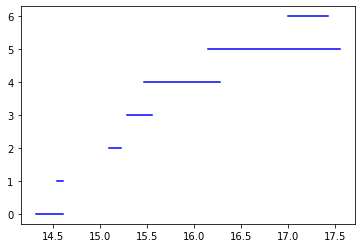

In [8]:
raduis = 20

question = ''
full_data = []
article_ids = []
for i, row in enumerate(news_data['text'][:100]):
    if i > 0:
            break
    #text_sample = news_data['text'][0]
    print(len(row))
    _, data, *_ = m(re.split('\. |\! |\? ', row))
    for sen_id, sentence in enumerate(data):
        if sen_id > 0:
            break
        print(sentence.max(), sentence.min())
        bar_emb(sentence, raduis)
    full_data.extend(data)
    
    article_ids.extend([i for _ in data])
    
    


14461
2.7350333 -3.4434593 20
Filtration with 327679 simplices
[Diagram with 20 points, Diagram with 4 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points]


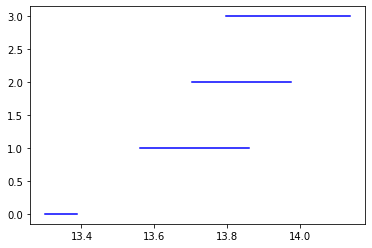

In [9]:
raduis = 20

question = ''
full_data = []
article_ids = []
for i, row in enumerate(news_data['text'][:100]):
    if i > 0:
            break
    #text_sample = news_data['text'][0]
    print(len(row))
    _, data, *_ = m(re.split('\. |\! |\? ', row))
    for sen_id, sentence in enumerate(data):
        if sen_id != 2:
            continue
        print(sentence.max(), sentence.min(), len(sentence))
        bar_emb(sentence, raduis)
    full_data.extend(data)
    
    article_ids.extend([i for _ in data])
    
    


# Use TDA for text similarity

We will apply TDA in text similarity from this paper https://arxiv.org/abs/2003.13138

In [10]:
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

In [11]:
import scipy.signal as signal
from scipy.spatial import distance


def smooth_sequence(embs):
    KERNEL = np.array([1/8,1/4,1/2,1/2,1/4,1/8])
    T,d = embs.shape
    local_kernel = np.tile(KERNEL, (1,d))
    embs[0] += KERNEL[0] * embs[0]
    embs[-1] += KERNEL[-1] * embs[-1]
    smoothed_embs = signal.convolve2d(embs, local_kernel, mode='same')
    return smoothed_embs

# def distance_matrix(embs):
#     T,d = embs.shape
#     matrix = np.zeros([T,T], dtype=np.float32)
#     for i in range(T):
#         emb_i = embs[i]
#         for j in range(T):
#             emb_j = embs[j] 
#             matrix[i,j] = 1/T * np.linalg.norm(emb_i/ np.sqrt(d)) * np.linalg.norm(emb_j/ np.sqrt(d)) * (distance.cosine(emb_i / np.sqrt(d), emb_j / np.sqrt(d)))
#     return matrix

def distance_matrix(embs):
    embs = embs.T
    d, T = embs.shape
    matrix = np.zeros([d,d], dtype=np.float32)
    for i in range(d):
        emb_i = embs[i]
        for j in range(d):
            emb_j = embs[j] 
            matrix[i,j] = 1/T * np.linalg.norm(emb_i) * np.linalg.norm(emb_j) * (distance.cosine(emb_i / T, emb_j / T))
    return matrix


def get_dmgs(embs):
    #smoothed = smooth_sequence(embs)
    dgms = ripser(embs.T, maxdim=1, distance_matrix=False)['dgms']
    return dgms


# def get_dmgs(embs):
#     smoothed = smooth_sequence(embs)
#     matrix = distance_matrix(embs)
#     dgms = ripser(matrix, maxdim=1, distance_matrix=True)['dgms']
#     return dgms





Example usage

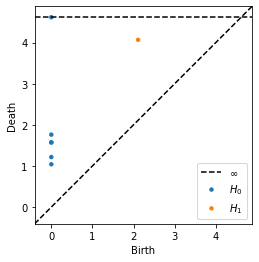

In [12]:
x = np.random.randn(20,100)
smoothed = smooth_sequence(x)
#print(smoothed.shape)
#print(smoothed)

#print(distance_matrix(smoothed).shape)
#print(get_dmgs(x))
distance_matrix(smoothed).max()
x = np.random.randn(20,100)
smoothed = smooth_sequence(x)

matrix = distance_matrix(smoothed)
dgms = ripser(matrix, maxdim=1, distance_matrix=True)['dgms']
plot_diagrams(dgms, show=True)

# Create persistent diagrams

Lets try to create the persistent diagrams for 5 first articles and compare them by wasserstein distance

14461


  2%|▏         | 2/94 [00:01<01:08,  1.34it/s]

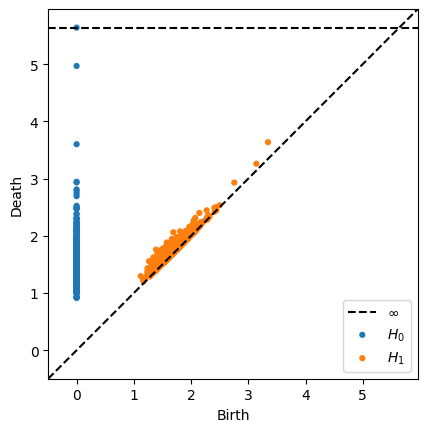

100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


1168


 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

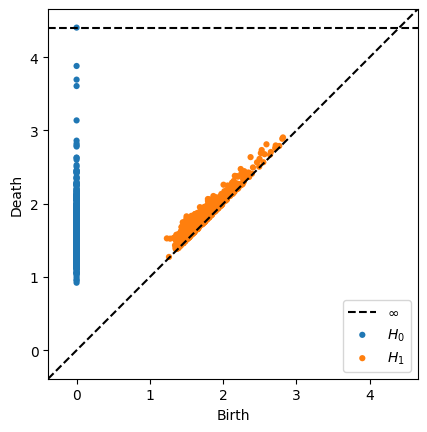

100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


1069


 17%|█▋        | 2/12 [00:01<00:06,  1.54it/s]

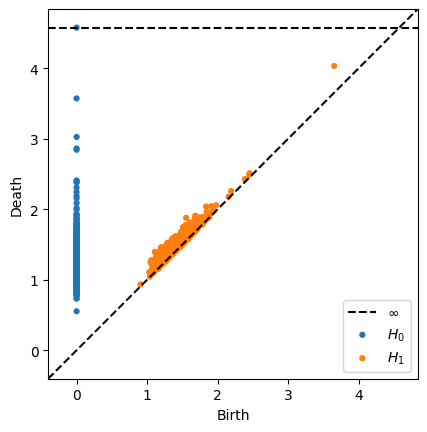

100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


20411


  1%|          | 2/176 [00:01<01:47,  1.61it/s]

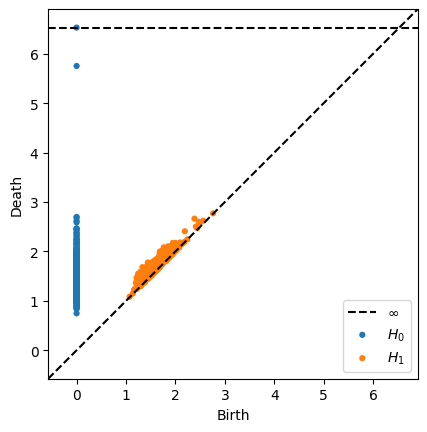

100%|██████████| 176/176 [01:49<00:00,  1.61it/s]


1058


 17%|█▋        | 2/12 [00:01<00:06,  1.58it/s]

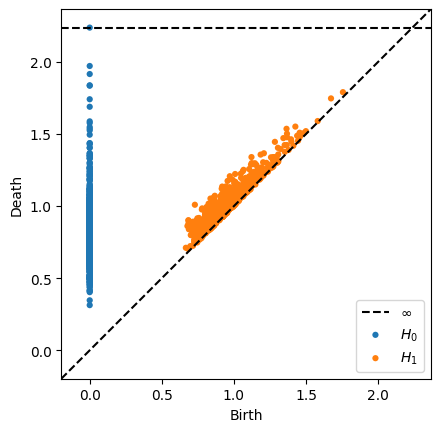

100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


In [13]:
full_data = []
for i, row in enumerate(news_data['text'][:5]):
    curr_data = []
    #text_sample = news_data['text'][0]
    print(len(row))
    _, data, *_ = m(re.split('\. |\! |\? ', row))
    for sen_id, sentence in tqdm(list(enumerate(data))):
        
        dgms = get_dmgs(sentence)
        if sen_id == 2:
            plot_diagrams(dgms, show=True)
        curr_data.append(dgms)
    full_data.append(curr_data)

Filter diagrams without loops

In [14]:
def filter_rips(dmgs):
    return [elem for elem in dmgs if type(elem)==list and len(elem)>=2 and len(elem[1]) >= 1]

print('before filtration', [len(el) for el in full_data])
full_data = [filter_rips(elem) for elem in full_data]
print('after_filtration', [len(el) for el in full_data])

before filtration [94, 11, 12, 176, 12]
after_filtration [94, 11, 12, 176, 12]


In [15]:
def find_min_distance(key_dmg, dmgs, axis=1):
    wdistance = []
    for el in dmgs:
        wdistance.append(persim.sliced_wasserstein(key_dmg[axis], el[axis]))
    return np.min(wdistance)

Compare diagrams

в акте освидетельствования  датированном 8 июня  днем аварии   говорится  что ефремов не отрицает употребление алкоголя


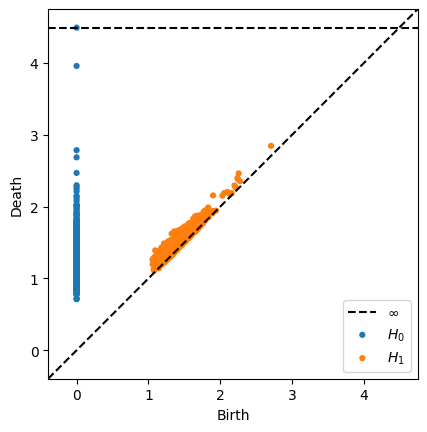

In [41]:
question = 'В акте освидетельствования, датированном 8 июня (днем аварии), говорится, что Ефремов не отрицает употребление алкоголя'
#question = 'Днем 9 июня Ефремова доставили на допрос в УВД по Центральному административному округу Москвы.'
#question = 'Проблемы ранней беременности существует во многих странах'

question = re.sub('\@|\$|\*|\[|\]|\(|\)|\"|\^|\~|\{|\}|\<|\>|\,|\'|\:|\»|\«' + '|\.|\!|\?', ' ', question).lower()
print(question)
_, data, *_ = m(re.split('\. |\! |\? ', question))        
question_dgm = get_dmgs(data[0])
plot_diagrams(question_dgm, show=True)

In [42]:
news_data.head()

,title,text
0,синий богатырь,в 1930-е годы советский союз охватила лихорадк...
1,загитова согласилась вести ледниковый период,олимпийская чемпионка по фигурному катанию ал...
2,объяснена опасность однообразного питания,российский врач-диетолог римма мойсенко объясн...
3,предохраняться? а зачем?,в 2019 году телеканал ю запустил адаптацию з...
4,ефремов систематически употреблял наркотики,актер михаил ефремов систематически употребл...


In [43]:
question

'в акте освидетельствования  датированном 8 июня  днем аварии   говорится  что ефремов не отрицает употребление алкоголя'

In [44]:
for i,dmgs in enumerate(full_data):
    print(i, find_min_distance(question_dgm, dmgs))

0 6.862851500586229
1 11.655346209092817
2 6.67508293719878
3 5.474059547177805
4 5.339287703917762


# Text Retrieval

As shown before, our data could be separated. We use SVM classifier to solve this task with 'ovo' strategy because for 2 differen articles data places in different clusters.

In [20]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [21]:

def vis_tsne(text_data, idxs):
    sentence_embs = []
    sentence_ids = []
    for i, row in tqdm(enumerate(text_data[idxs]), total=len(idxs)):
        _, data, *_, sent_mean_embs, _ = m(re.split('\. |\! |\? ', row))
        sentence_embs.extend(list(sent_mean_embs))
        sentence_ids.extend([i for _ in range(len(sent_mean_embs))])

    #mapper = manifold.TSNE(n_components=N_COMPONENTS)
    mapper = PCA(n_components=N_COMPONENTS)
    sentences_2d = np.stack(sentence_embs)
    print(sentences_2d.shape)
    tsne_results = mapper.fit_transform(sentences_2d)

    plt.figure(figsize=(10, 10))

    sentence_label = np.array(sentence_ids)
    for i, c in zip(sentence_label, sentence_ids):
        plt.scatter(tsne_results[sentence_label == i, 0], tsne_results[sentence_label == i, 1], label=sentence_ids)
    plt.show()

Visualize 2 different articles

100%|██████████| 2/2 [00:22<00:00, 11.26s/it]


(270, 768)


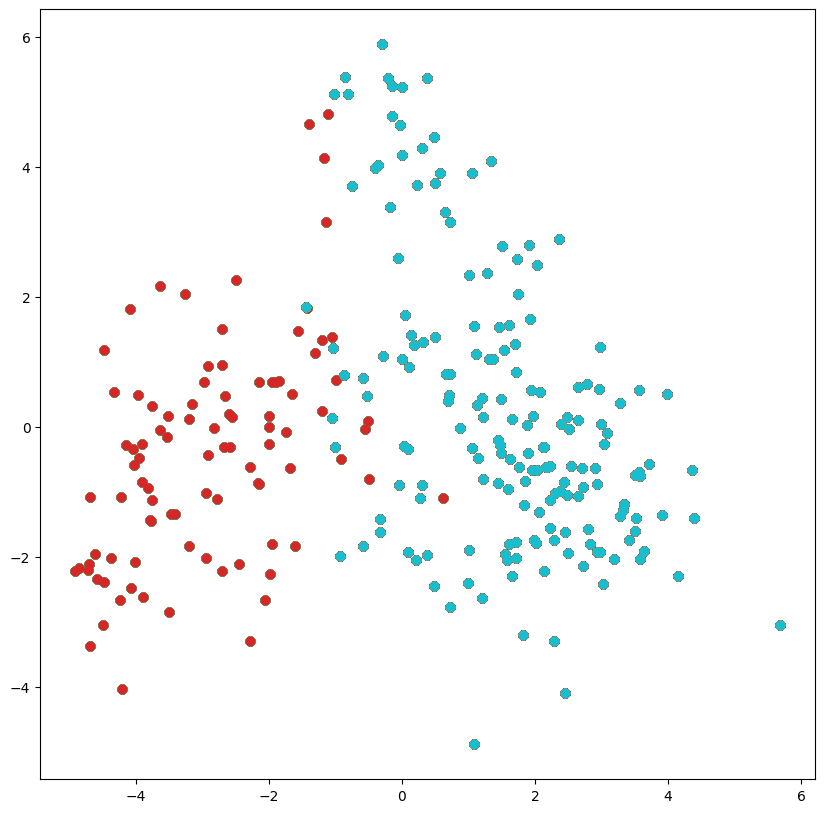

In [22]:

vis_tsne(news_data['text'], [0,3])

100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


(33, 768)


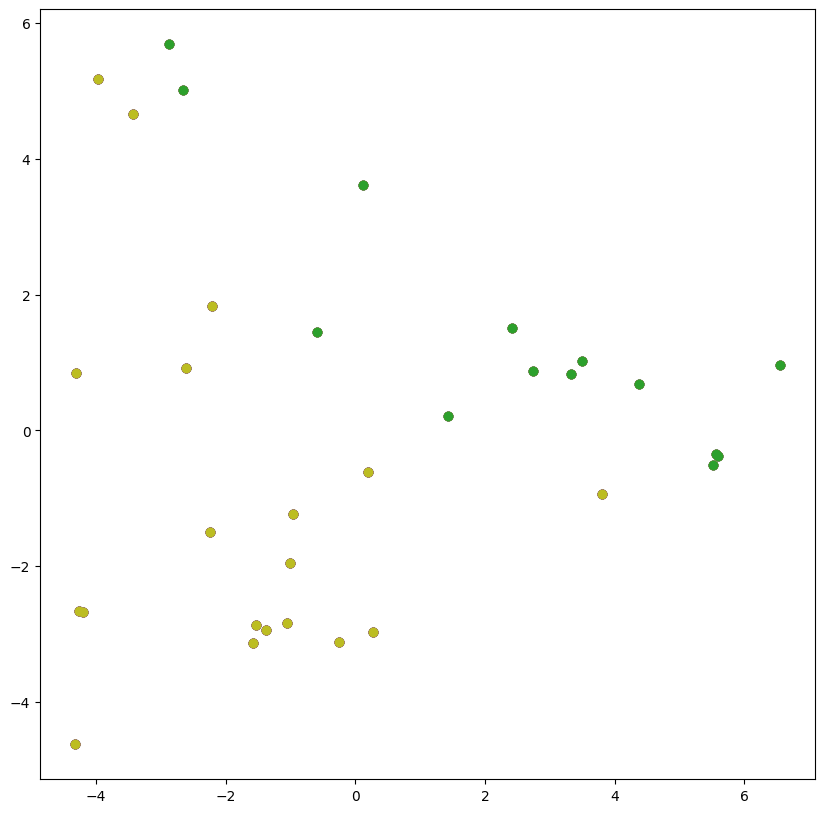

In [31]:

vis_tsne(news_data['text'], [6,11])

In [24]:

NEWS_SIZE = 200

sentence_embs = []
sentence_ids = []
for i, row in tqdm(enumerate(news_data['text'][:NEWS_SIZE]), total=NEWS_SIZE):
    _, data, *_, sent_mean_embs, _ = m(re.split('\. |\! |\? ', row))
    sentence_embs.extend(list(sent_mean_embs))
    sentence_ids.extend([i for _ in range(len(sent_mean_embs))])


sentence_embs = np.array(sentence_embs)
sentence_ids = np.array(sentence_ids)

X_train, X_test, y_train, y_test = train_test_split(
    sentence_embs, sentence_ids, test_size=0.2, random_state=42)


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


# Some experiments

By using TDA we found that data can be placed into 2 different cluster on 2d space separated by line. By this knowlegde we use SVM classifier with linear kernel to find nearest paper to query.

SVC with default kernel

In [25]:
clf = make_pipeline(SVC(gamma='auto', decision_function_shape='ovo', kernel='rbf'))
clf.fit(X_train, y_train)
print('SVC with default rbf kernel ovo score', clf.score(X_test, y_test))


SVC with default rbf kernel ovo score 0.20246478873239437


SVC with no kernel

In [26]:

clf = make_pipeline(PCA(N_COMPONENTS), SVC(gamma='auto', decision_function_shape='ovo', kernel='linear'))
clf.fit(X_train, y_train)
print('SVC with linear kernel ovo score  with PCA', clf.score(X_test, y_test))

SVC with linear kernel ovo score  with PCA 0.11091549295774648


In [27]:
clf = make_pipeline(SVC(gamma='auto', decision_function_shape='ovo', kernel='linear'))
clf.fit(X_train, y_train)
print('SVC with linear kernel ovo score', clf.score(X_test, y_test))


SVC with linear kernel ovo score 0.4119718309859155


As we see by using TDA we can analyse the distribution lies for data and use simple and fast algorythms to make fast and acceptable baseline and then find better solution

## Clustering
At first, lets prepare data for clustering

In [79]:
full_data = []
article_ids = []
article_size = []
for i, row in enumerate(news_data['text'][15:18]):
    #text_sample = news_data['text'][0]
    _, data, *_ = m(re.split('\. |\! |\? ', row))
    article_size.append(data[0].shape[0])
    full_data.extend([i for i in data])
    article_ids.extend([i for _ in data])

full_data = np.stack(data.mean(0) for data in full_data)
full_data = np.nan_to_num(full_data)

/home/vsevolod/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### KMeans
KMeans clustering algorythm with n_clusters = 3 (number of articles for clusterization)

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

print(full_data.shape)
kmeans = KMeans(n_clusters=3, random_state=2).fit(full_data)
result = kmeans.predict(full_data)

print(result)

(73, 768)
[0 2 0 2 2 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0]


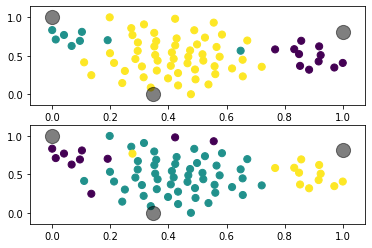

In [86]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

N_COMPONENTS = 2

mapper = km.KeplerMapper(verbose=0)
projected_data = mapper.fit_transform(full_data, projection=manifold.TSNE(n_components=N_COMPONENTS, random_state=40)) 
projected_centres = mapper.fit_transform(kmeans.cluster_centers_, projection=manifold.TSNE(n_components=N_COMPONENTS, random_state=42))
fig, axs = plt.subplots(2)
axs[0].scatter(projected_data[:, 0], projected_data[:, 1], c=result, s=50, cmap='viridis')

axs[0].scatter(projected_centres[:, 0], projected_centres[:, 1], c='black', s=200, alpha=0.5)

axs[1].scatter(projected_data[:, 0], projected_data[:, 1], c=article_ids, s=50, cmap='viridis')
axs[1].scatter(projected_centres[:, 0], projected_centres[:, 1], c='black', s=200, alpha=0.5)


### Spectral Clustering
Spectral clustering algorythm with n_clusters=3 (number of articles for clusterization)

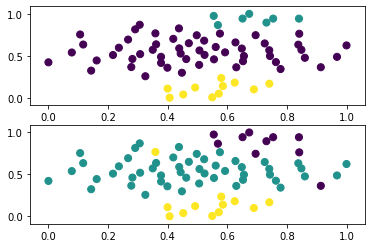

In [87]:
from sklearn.cluster import SpectralClustering

result = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=5).fit_predict(full_data)

projected_data = mapper.fit_transform(full_data, projection=manifold.TSNE(n_components=N_COMPONENTS, random_state=42)) 
fig, axs = plt.subplots(2)

axs[0].scatter(projected_data[:, 0], projected_data[:, 1], c=result, s=50, cmap='viridis')
axs[1].scatter(projected_data[:, 0], projected_data[:, 1], c=article_ids, s=50, cmap='viridis')

### Gaussian Mixture

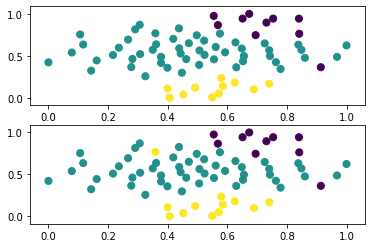

In [89]:
from sklearn.mixture import GaussianMixture
gaussian = GaussianMixture(n_components=3, covariance_type='diag')
result = gaussian.fit_predict(full_data)
projected_data = mapper.fit_transform(full_data, projection=manifold.TSNE(n_components=N_COMPONENTS, random_state=42)) 
fig, axs = plt.subplots(2)
axs[0].scatter(projected_data[:, 0], projected_data[:, 1], c=result, s=50, cmap='viridis')
axs[1].scatter(projected_data[:, 0], projected_data[:, 1], c=article_ids, s=50, cmap='viridis')

As we could see in the examples above, our articles could be clusterized